In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import itertools
import datetime
# Maybe use https://gitlab.com/mike01/pypacker or https://stackoverflow.com/questions/30826123/python-scapy-vs-dpkt
import scapy
import pickle
import subprocess
from subprocess import PIPE
from pathlib import Path
from datetime import datetime, timedelta
import networkx as nx
import matplotlib.dates as mdates
import statistics
import re
import sharedVariables
from sharedVariables import *
import matplotlib
matplotlib.rcParams.update({'errorbar.capsize': 4})


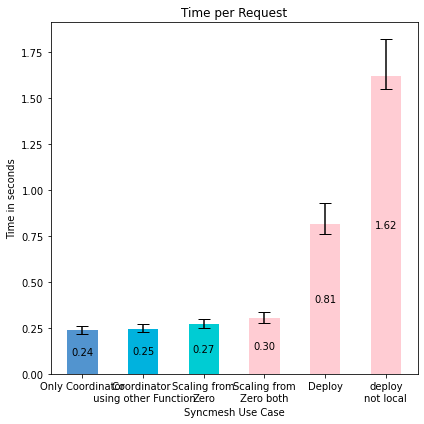

In [49]:
matplotlib.rcParams.update({'errorbar.capsize': 6})

# source = "./data/special-syncmesh/20220202-02-extra-function-30-days"
source = "./data/special-syncmesh/20220205-22-all-functions"

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def convertToTime(s):
    try:
        return (datetime.strptime(s.strip(), "%M:%S.%f") - datetime(1900, 1, 1)).total_seconds()
    except Exception as e:
        return None

def loadTimings(source, func):
    return_data = {}
    with open(source + "/" + func + ".timings") as f:
        return_data = list(chunks(list(filter(None, map(lambda s: convertToTime(s), f.readlines()))), 40))
    return return_data

colors = ["#5294CF", "#00B2DE", "#00CCD3", "#FFCCD3", "#FFCCD3", "#FFCCD3"]

fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(6, 6))

datasets = ["normal", "function", "cold", "cold_both", "deploy", "deploy_notlocal"]
# datasets = ["server-normal", "server-function", "server-cold", "server-cold-both"]

for index, dataset in enumerate(datasets):
    timings = loadTimings(source, dataset)

    timing = timings[0]
    y = statistics.mean(timing)
    y_max = max(timing) - y
    y_min = abs(min(timing) - y)

    bar = ax.bar(0 + (2 * index), y, yerr = [[y_min], [y_max]], color = colors[index], width = 1, ecolor='black')
    ax.bar_label(bar, label_type='center',fmt='%.2f')

# set title and legend
ax.set_title('Time per Request')
ax.set_ylabel("Time in seconds")
ax.set_xlabel("Syncmesh Use Case")
# ax.legend(labels=datasets)

# box = ax.get_position()
# # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
# fig.autofmt_xdate()
plt.xticks([0,2,4,6,8,10], ["Only Coordinator", "Coordinator \n using other Function", "Scaling from\nZero", "Scaling from\nZero both", "Deploy", "deploy\nnot local"]) #"Loading\nsecondary function"
fig.savefig(f'out/syncmesh_function_timing.png')

plt.show()

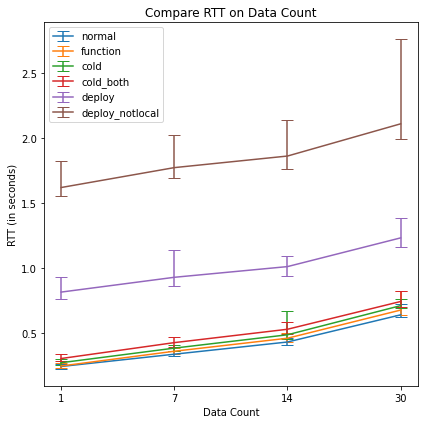

In [46]:
compare_timings = {}
for dataset in datasets:
    compare_timings[dataset] = {}
    compare_timings[dataset]["value"] = []
    compare_timings[dataset]["max"] = []
    compare_timings[dataset]["min"] = []

    timings = loadTimings(source, dataset)
    for index, scenario in enumerate(['1', '7', '14', "30"]):
        timing = timings[index]
        y = statistics.mean(timing)
        y_max = max(timing) - y
        y_min = abs(min(timing) - y)

        compare_timings[dataset]["value"].append(y)
        compare_timings[dataset]["max"].append(y_max)
        compare_timings[dataset]["min"].append(y_min)


def drawComparisonGraphTimings(df):
    fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(6, 6))
    for col in datasets: 
        #ax.plot(3 + df.index * 3, df[col + "_value"], label=col)
        ax.errorbar(3 + df.index * 3, df[col + "_value"], label=col, yerr = [df[col + "_min"], df[col + "_max"]])
        

    # set title and legend
    ax.set_title("Compare RTT on Data Count")
    ax.set_ylabel("RTT (in seconds)")
    ax.set_xlabel("Data Count")

    x_locator = matplotlib.ticker.FixedLocator(np.array(list(range(1, len(df.index) +1))) * 3)
    ax.xaxis.set_major_locator(x_locator)
    ax.legend(loc='upper left') # , bbox_to_anchor=(1.05, 1)
    ax.set_xticklabels(["1", "7", "14", "30"])

    fig.savefig("out/sycmesh_comparison_timings.png")
    plt.show()

compare_table_timing = pd.DataFrame(dict(
        normal_value=compare_timings["normal"]["value"],
        normal_max=compare_timings["normal"]["max"],
        normal_min=compare_timings["normal"]["min"],
        function_value=compare_timings["function"]["value"],
        function_max=compare_timings["function"]["max"],
        function_min=compare_timings["function"]["min"],
        cold_value=compare_timings["cold"]["value"],
        cold_max=compare_timings["cold"]["max"],
        cold_min=compare_timings["cold"]["min"],
        cold_both_value=compare_timings["cold_both"]["value"],
        cold_both_max=compare_timings["cold_both"]["max"],
        cold_both_min=compare_timings["cold_both"]["min"],
        deploy_value=compare_timings["deploy"]["value"],
        deploy_max=compare_timings["deploy"]["max"],
        deploy_min=compare_timings["deploy"]["min"],
        deploy_notlocal_value=compare_timings["deploy_notlocal"]["value"],
        deploy_notlocal_max=compare_timings["deploy_notlocal"]["max"],
        deploy_notlocal_min=compare_timings["deploy_notlocal"]["min"],
))

drawComparisonGraphTimings(compare_table_timing)